Content list 
1)deleting full name
2) adding states 
3)removing low consumers buyers 
4)creating consumer profiles 
5)creating charts based off consumer profiles 

In [1]:
#importing relevent libaries 

import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
# creating path for data import 
path = r'/Users/thomaskimber/Desktop/Instacart Basket Analysis'

In [3]:
df_full = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'df_full.4.9.1.pkl'))

In [4]:
#dropping first name for PII reasons 
df_full = df_full.drop(columns=['first_name'])

In [5]:
#checking for missing values in the days since pior order to confrim why we think they are missing 
crosstab = pd.crosstab(df_full['days_since_prior_order'], df_full['order_number'], dropna = False)

In [6]:
crosstab.to_clipboard()

In [7]:
# Define U.S. regions based on states
northeast = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont',
             'New Jersey', 'New York', 'Pennsylvania']

midwest = ['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri',
           'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin']

south = ['Alabama', 'Arkansas', 'Delaware', 'District of Columbia', 'Florida', 'Georgia',
         'Kentucky', 'Louisiana', 'Maryland', 'Mississippi', 'North Carolina', 'Oklahoma',
         'South Carolina', 'Tennessee', 'Texas', 'Virginia', 'West Virginia']

west = ['Alaska', 'Arizona', 'California', 'Colorado', 'Hawaii', 'Idaho', 'Montana', 'Nevada',
        'New Mexico', 'Oregon', 'Utah', 'Washington', 'Wyoming']

# Function to assign a region based on the state
def assign_region(state):
    if state in northeast:
        return 'Northeast'
    elif state in midwest:
        return 'Midwest'
    elif state in south:
        return 'South'
    elif state in west:
        return 'West'
    else:
        return 'Other'

# Apply the function to create a new 'Region' column
df_full['Region'] = df_full['state'].apply(assign_region)

In [8]:
df_full['Region'].value_counts()

Region
South        10791885
West          8292913
Midwest       7597325
Northeast     5722736
Name: count, dtype: int64

In [9]:
#creating exclusion flag 
df_full['exclusion_flag'] = df_full['max_order'].apply(lambda x: 'Exclude' if x < 5 else 'Include')

Created a new df called df_active for only customer with over 5 orders 

In [10]:
df_active = df_full[df_full['exclusion_flag'] == 'Include']

In [11]:
np.random.seed(4)
dev = np.random.rand(len(df_active)) <= 0.7

big = df_active[dev].copy()
small = df_active[~dev].copy()

In [12]:
dept_map = {
    '1': 'frozen',
    '2': 'other',
    '3': 'bakery',
    '4': 'produce',
    '5': 'alcohol',
    '6': 'international',
    '7': 'beverages',
    '8': 'pets',
    '9': 'dry goods pasta',
    '10': 'bulk',
    '11': 'personal care',
    '12': 'meat seafood',
    '13': 'pantry',
    '14': 'breakfast',
    '15': 'canned goods',
    '16': 'dairy eggs',
    '17': 'household',
    '18': 'babies',
    '19': 'snacks',
    '20': 'deli',
    '21': 'missing'
}

# Map department_id to department name in small df
small['department'] = small['department_id'].astype(str).map(dept_map)

#creating consumer profile using age, income, dependants, deparments, day and hour 

In [13]:
def assign_profile(row):
    age = row['age']
    income = row['income']
    n_dep = row['n_dependants']
    dept = row['department']
    day = row['orders_day_of_week']
    hour = row['hour_of_the_day_for_order']

    # Example rules (customize as needed)
    if age < 30 and n_dep == 0 and income < 40000:
        return 'Young Single (Low Income)'
    elif age < 40 and n_dep > 0:
        return 'Young Parent'
    elif age >= 40 and n_dep > 0 and income > 60000:
        return 'Affluent Family'
    elif age >= 50 and n_dep == 0 and income > 50000:
        return 'Older Professional'
    elif day in [5, 6] and hour >= 18:
        return 'Weekend Shopper'
    elif dept == 'babies':
        return 'Baby Products Buyer'
    elif dept == 'alcohol':
        return 'Alcohol Buyer'
    else:
        return 'Other'

small['profile'] = small.apply(assign_profile, axis=1)

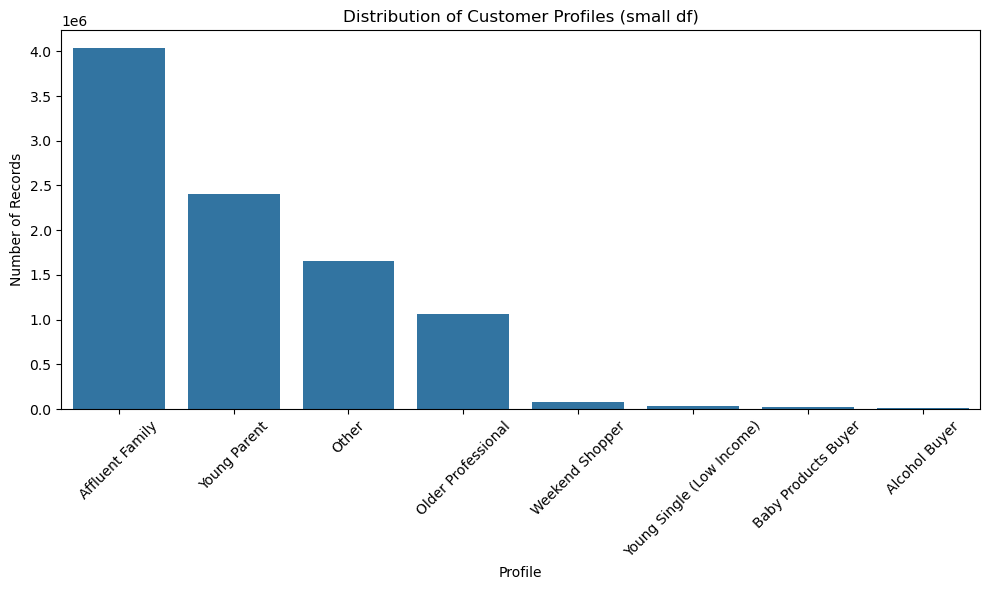

In [15]:
# Plot profile distribution without saving
plt.figure(figsize=(10, 6))
sns.countplot(data=small, x='profile', order=small['profile'].value_counts().index)
plt.title('Distribution of Customer Profiles (small df)')
plt.xlabel('Profile')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# getting rid of the max price 
small.loc[small['prices'] > 100, 'prices'] = np.nan

In [18]:
# Group by user and profile
user_summary = small.groupby(['user_id', 'profile']).agg({
    'order_number': 'max',         # max order number = total orders
    'prices': ['mean', 'max', 'min']
}).reset_index()

# Flatten columns
user_summary.columns = ['user_id', 'profile', 'max_orders', 'avg_price', 'max_price', 'min_price']

# Aggregate on profile level
profile_agg = user_summary.groupby('profile').agg({
    'max_orders': ['mean', 'max', 'min'],
    'avg_price': ['mean', 'max', 'min'],
}).round(2)

print(profile_agg)

                          max_orders         avg_price            
                                mean max min      mean    max  min
profile                                                           
Affluent Family                19.02  99   1      8.05  22.80  1.1
Alcohol Buyer                  13.18  99   1      7.73  15.00  1.0
Baby Products Buyer            19.09  99   1      7.36  15.00  1.0
Older Professional             19.03  99   1      7.96  16.44  1.3
Other                          17.74  99   1      7.13  19.65  1.0
Weekend Shopper                15.88  99   1      7.33  24.70  1.0
Young Parent                   18.73  99   1      7.76  22.20  1.0
Young Single (Low Income)      15.72  99   1      6.34  13.35  1.1


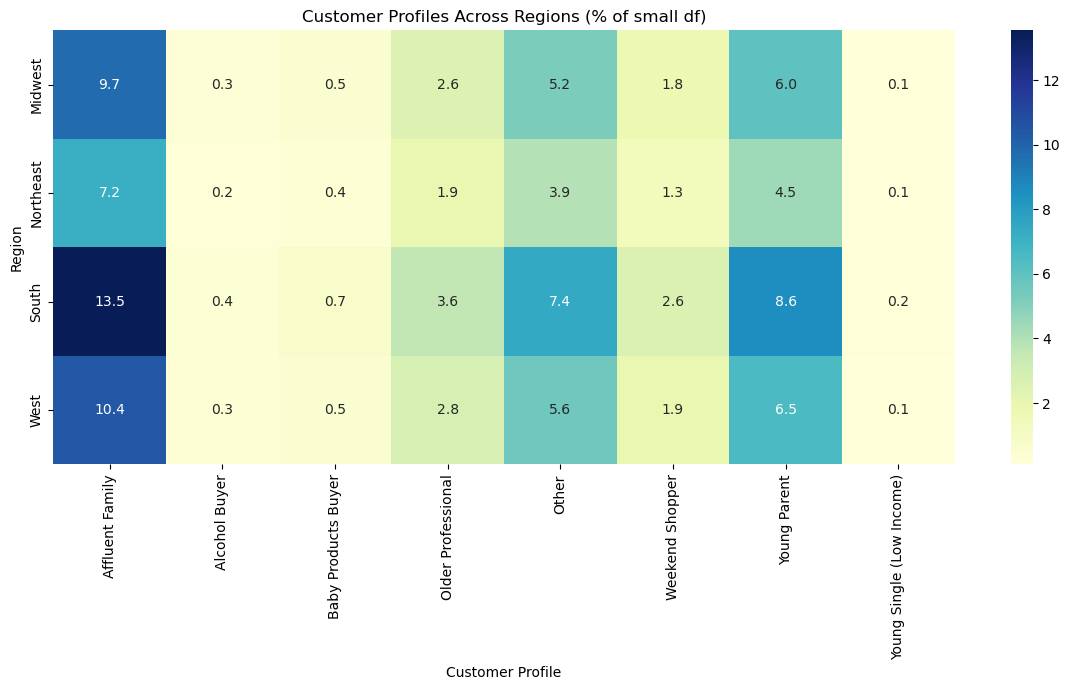

In [22]:
# Total number of unique users in small
total_users = small['user_id'].nunique()

# Count unique users by Region and profile
region_profile = small.groupby(['Region', 'profile'])['user_id'].nunique().reset_index()

# Add percentage column
region_profile['percent'] = (region_profile['user_id'] / total_users) * 100

# Pivot table for heatmap
region_pivot = region_profile.pivot(index='Region', columns='profile', values='percent').fillna(0)

# Plot heatmap (percentages)
plt.figure(figsize=(12, 7))
sns.heatmap(region_pivot, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Customer Profiles Across Regions (% of small df)')
plt.xlabel('Customer Profile')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

creating a heat map of profile vs departments ordered by them 

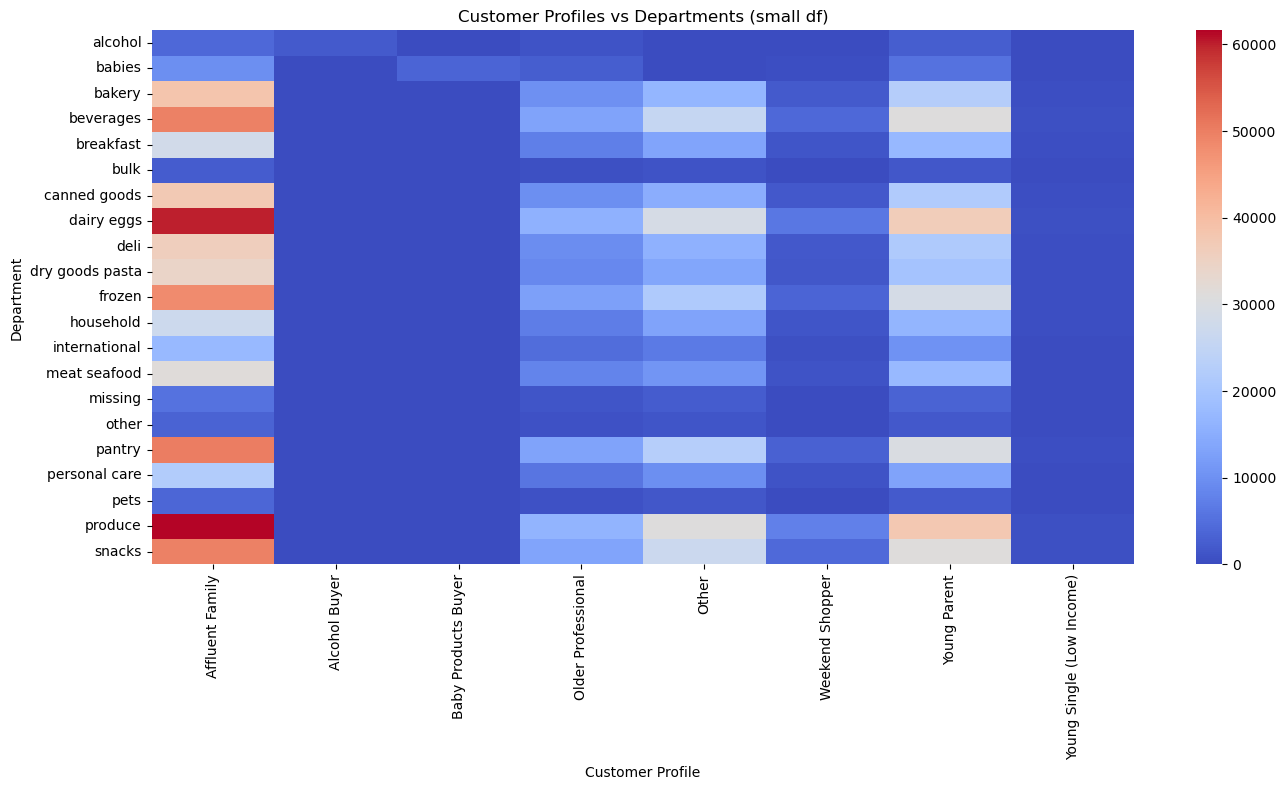

In [23]:
# Group and count unique users per profile per department
dept_profile = small.groupby(['department', 'profile'])['user_id'].nunique().reset_index()

# Pivot for heatmap
dept_pivot = dept_profile.pivot(index='department', columns='profile', values='user_id').fillna(0)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(dept_pivot, annot=False, cmap='coolwarm')
plt.title('Customer Profiles vs Departments (small df)')
plt.xlabel('Customer Profile')
plt.ylabel('Department')
plt.tight_layout()
plt.show()

Creating a bar chart of disturbution of profiles accorss the different regions 

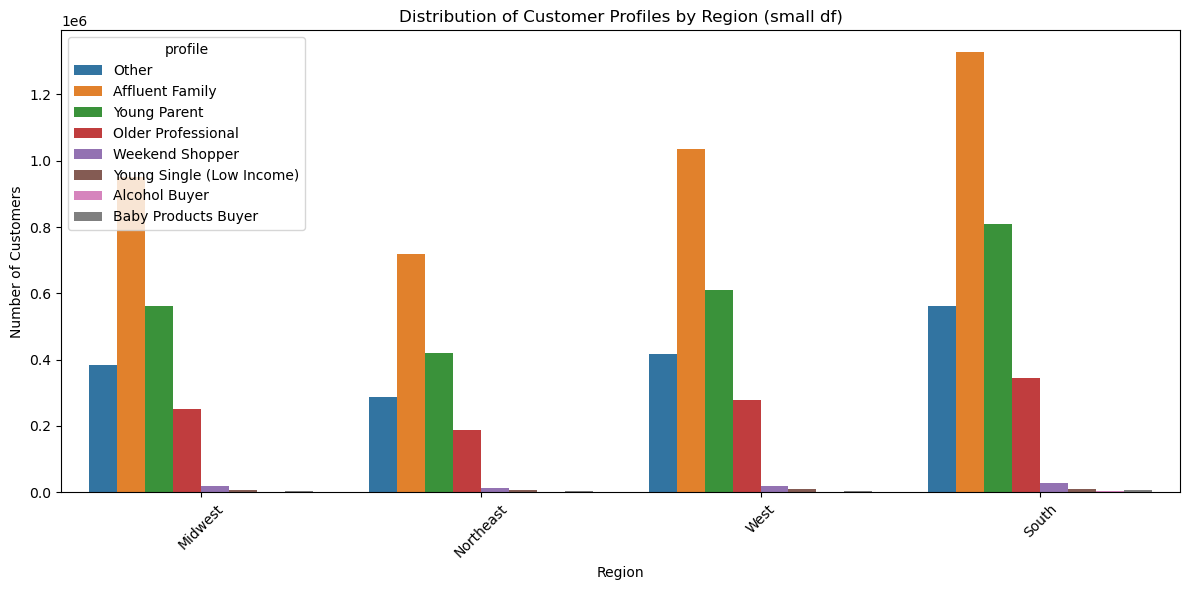

In [25]:
plt.figure(figsize=(12, 6))
sns.countplot(data=small, x='Region', hue='profile')
plt.title("Distribution of Customer Profiles by Region (small df)")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

creating a bar chart on Distribution of Customer Profiles by Department 

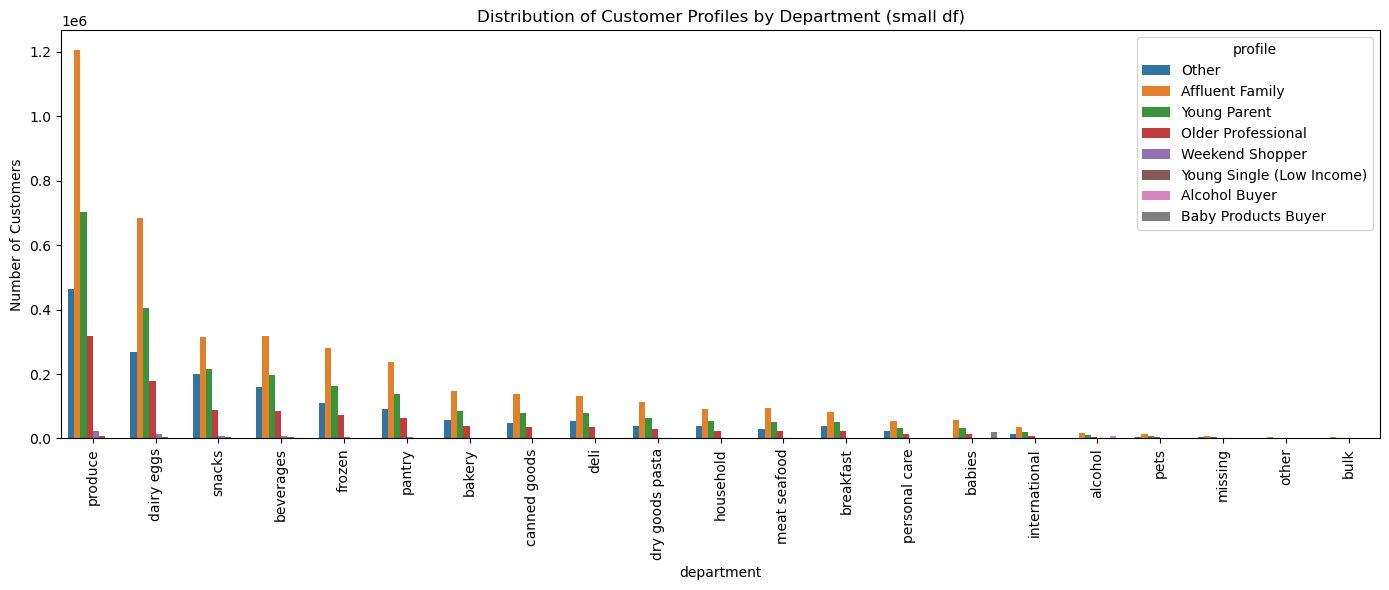

In [26]:
plt.figure(figsize=(14, 6))
sns.countplot(data=small, x='department', hue='profile', order=small['department'].value_counts().index)
plt.title("Distribution of Customer Profiles by Department (small df)")
plt.ylabel("Number of Customers")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [27]:
#I cant export data frame because I have no memeory left. Unless i can delete olders data frame but I believe this wouldnt be wise